# 2. End-to-End Machine Learning Project

In this Chapter, we will go through a fictitious Machine Learning project on real estate.

We will go through the following steps:

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune our model
7. Present our solution
8. Launch, monitor, and maintain our system

### 1. Look at the big picture

Three main things to do:

1. **Frame the problem**：what is the final objective?
2. **Select a performance measure**: how do we know how well is our algorithm performing? 
3. **Check the assumptions**: what did we assume so far? 

### 2. Get the data

First thing to do is to create the **workspace**. 
Another important step is creating an isolated environment so we can work on different projects without having conflicting library versions. 

Now we can start working with our Housing dataset. Let's download it using a short script:

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

In [4]:
# download the data
fetch_housing_data()

In [5]:
# load data using pandas
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
# check the data structure
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# examine attribute types and number of non-null values
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


Note how `total_bedrooms` has only 20,433 non-null values, compared to 20,640 for the rest.

Let's inspect `ocean_proximity`, the only category which is not a numberical attribute (`float64` data type):

In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

For numberical attributes, we can use the `describe()` method:

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a **histogram** for each numerical attribute.

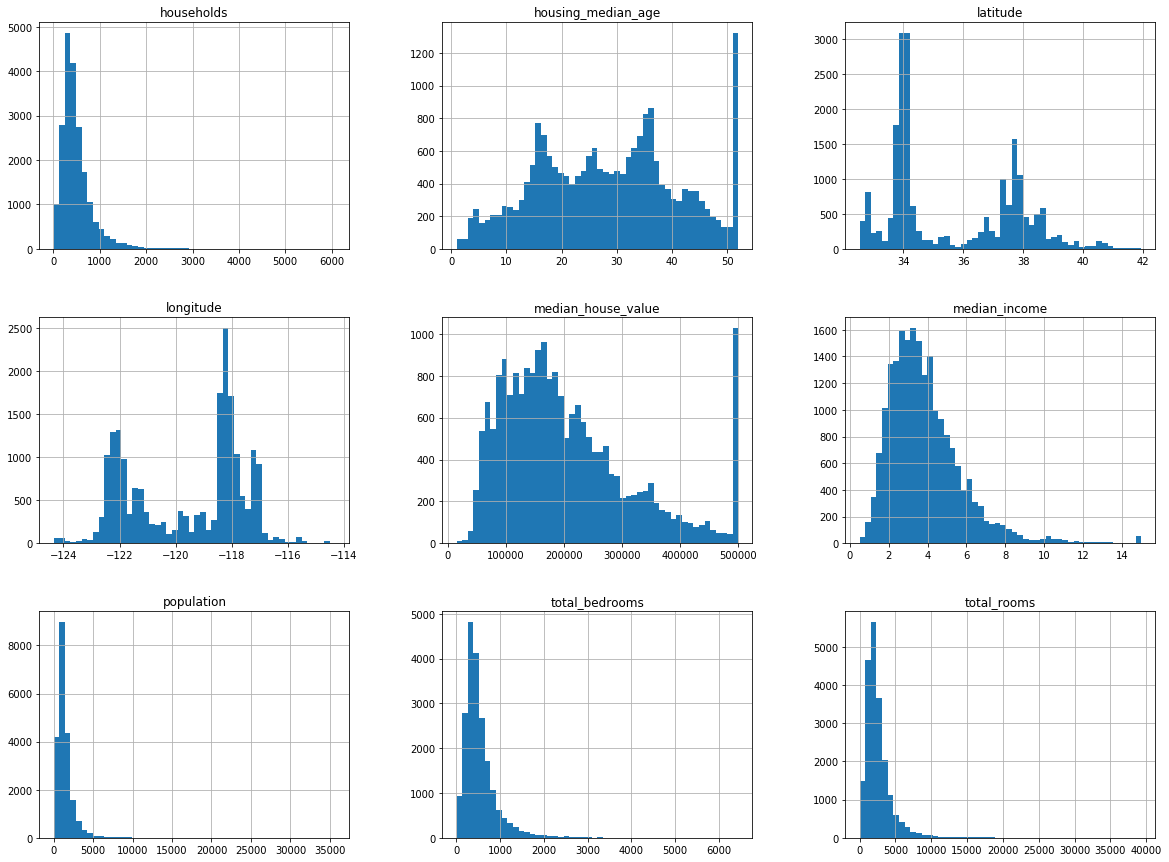

In [10]:
%matplotlib inline 
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

#### Creating a Test Set

It is good practice to set aside a portion of the dataset as test set as soon as possible (and not look at it ever again!).  
Typically we can do this by setting aside 20% of the original dataset: 

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

However, this has a problem: everytime we run the program again it will generate a different test set so over time, you will go through the whole dataset again. Not good. 

Possible solutions:
1. Save the test set on the first run and then load it in subsequent runs
2. Set the random number generator’s seed (e.g.,  `np.ran dom.seed(42)`) always to same value before calling `np.random.permutation()` 

**Note**: clearly, my seed was chosen very very randomly here. 

However, both these may break with updated datasets. A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (_assuming instances have a unique and immutable identifier_).

In [12]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, our housing dataset does not have an identifier column. We could use the row index as id: 

In [14]:
import numpy as np

housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

However, this creates contraints: we can only append at the end of the dataset, and no row can be deleted.  
Aleternatively, we could use latitute and longitude:

In [15]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

Next, to ensure **stratified sampling**, we may want to create an income category attribute with 5 categories:

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

We can now to stratified sampling using Scikit-learn's `StratifiedShuffleSplit` class:

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Let's see the proportion that went in different bins:

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

Let's remove the `income_cat` attribute so the data is back to its original state:

In [22]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### 3. Discover and visualize the data to gain insights

1. We are only exploring the **training set**
2. If dataset is to big, it's good to have an **exploration set** for ease of manipulation
3. Always make a copy so you can mess around without worries

In [23]:
housing = strat_train_set.copy()

### Visualizing geographical data

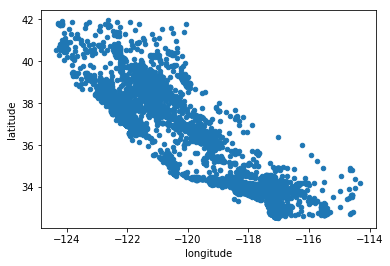

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Let's diminuish alpha so we can see where there is a higher density of points:

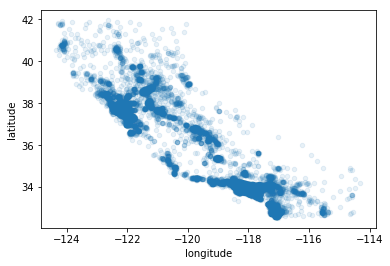

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)